In [ ]:
!pip install statsmodels

In [ ]:
# Imports
#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
  #  for filename in filenames:
  #      print(os.path.join(dirname, filename))

import statsmodels.api as sm
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.callbacks import LearningRateScheduler
from keras.layers import LSTM, Dense, TimeDistributed, RepeatVector

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [ ]:
!pip install shap==0.41.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for shap: filename=shap-0.41.0-cp311-cp311-linux_x86_64.whl size=518477 sha256=a589f915fb0d343ee0e33ed2b33c84de41864d951a81cb826781598d01bcdc7d
  Stored in directory: /root/.cache/pip/wheels/2a/ca/9d/d8f6a34c245842f4ad8e5afb5e8f217b8914f6d957d9e302fd
Successfully built shap
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.8
    Uninstalling slicer-0.0.8:
      Successfully uninstalled slicer-0.0.8
  Attempting uninstall: shap
    Found existing installation: shap 0.46.0
    Uninstalling shap-0.46.0:
      Successfully uninstalled shap-0.46.0


In [ ]:
### Load Dataset
DATA_PATH = "/content/Air Quality.csv"
df = pd.read_csv(DATA_PATH)
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


### Preprocess Data

In [ ]:
### Drop unwanted columns

# I will use all availaable features to predict temperature for the next n hours, let the DL model implicitly perform feature selection.
df.drop(columns = df.columns[-2:], axis = 1, inplace = True)
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [ ]:
# Description 1
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(13), object(2)
memory usage: 1.1+ MB


In [ ]:
# Description 2
df.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


In [ ]:
# Column wise
df[df != -200].isna().sum()

,0
Date,114
Time,114
CO(GT),1797
PT08.S1(CO),480
NMHC(GT),8557
C6H6(GT),480
PT08.S2(NMHC),480
NOx(GT),1753
PT08.S3(NOx),480
NO2(GT),1756


In [ ]:
# Drop noise

# There is min value of -200 on all the features which indicates something is wrong, I will drop all those values for now along with null values.
df.drop(columns = ["NMHC(GT)"], inplace = True)
df = df[df != -200].dropna().reset_index()
df.describe()

,index,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,6941.00000,6941.000000,6941.000000,6941.000000,6941.000000,6941.000000,6941.000000,6941.000000,6941.000000,6941.000000,6941.000000,6941.000000,6941.000000
mean,4831.76113,2.182467,1119.913269,10.554488,958.543005,250.671949,816.893387,113.874082,1452.648898,1057.756519,17.755323,48.881905,0.985573
std,2835.99290,1.441158,218.733754,7.465226,264.055002,208.611371,251.897200,47.475017,353.301576,406.509957,8.844909,17.433193,0.401097
min,0.00000,0.100000,647.000000,0.200000,390.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700
25%,2315.00000,1.100000,956.000000,4.900000,760.000000,103.000000,642.000000,79.000000,1207.000000,760.000000,11.200000,35.300000,0.694100
50%,5075.00000,1.900000,1085.000000,8.800000,931.000000,186.000000,786.000000,110.000000,1457.000000,1006.000000,16.800000,49.200000,0.953900
75%,7392.00000,2.900000,1254.000000,14.600000,1135.000000,335.000000,947.000000,142.000000,1683.000000,1322.000000,23.700000,62.200000,1.251600
max,9356.00000,11.900000,2040.000000,63.700000,2214.000000,1479.000000,2683.000000,333.000000,2775.000000,2523.000000,44.600000,88.700000,2.180600


In [ ]:
# Move the target column to the last index
target_col = df.pop('T')
df.insert(len(df.columns), 'T', target_col)
df.drop(columns = ['Date', 'index'], inplace = True)
df.head()

,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),RH,AH,T
0,18:00:00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,48.9,0.7578,13.6
1,19:00:00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,47.7,0.7255,13.3
2,20:00:00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,54.0,0.7502,11.9
3,21:00:00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,60.0,0.7867,11.0
4,22:00:00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,59.6,0.7888,11.2


In [ ]:
# Scale & Encode the data for numerical stability
label_encoder = LabelEncoder()
df['Time'] = label_encoder.fit_transform(df['Time'])

# Select numerical columns
numerical_columns = df.select_dtypes(include = ['int', 'float']).columns

# Perform standard scaling
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

df.head()

,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),RH,AH,T
0,0.877653,0.289742,1.097700,0.180250,0.331231,-0.405913,0.949291,-0.018413,0.677518,0.517229,0.001038,-0.567916,-0.469832
1,1.024422,-0.126620,0.786797,-0.154660,-0.013419,-0.707932,1.417770,-0.460783,0.301042,-0.210973,-0.067801,-0.648451,-0.503752
2,1.171191,0.012167,1.289728,-0.208246,-0.074016,-0.573701,1.282785,0.002653,0.289720,0.039961,0.293605,-0.586865,-0.662047
3,1.317960,0.012167,1.170853,-0.181453,-0.039930,-0.377149,1.092217,0.171174,0.371809,0.357320,0.637800,-0.495858,-0.763808
4,1.464728,-0.404195,0.695355,-0.543156,-0.464115,-0.573701,1.540845,0.044783,0.105728,0.128526,0.614854,-0.490622,-0.741194


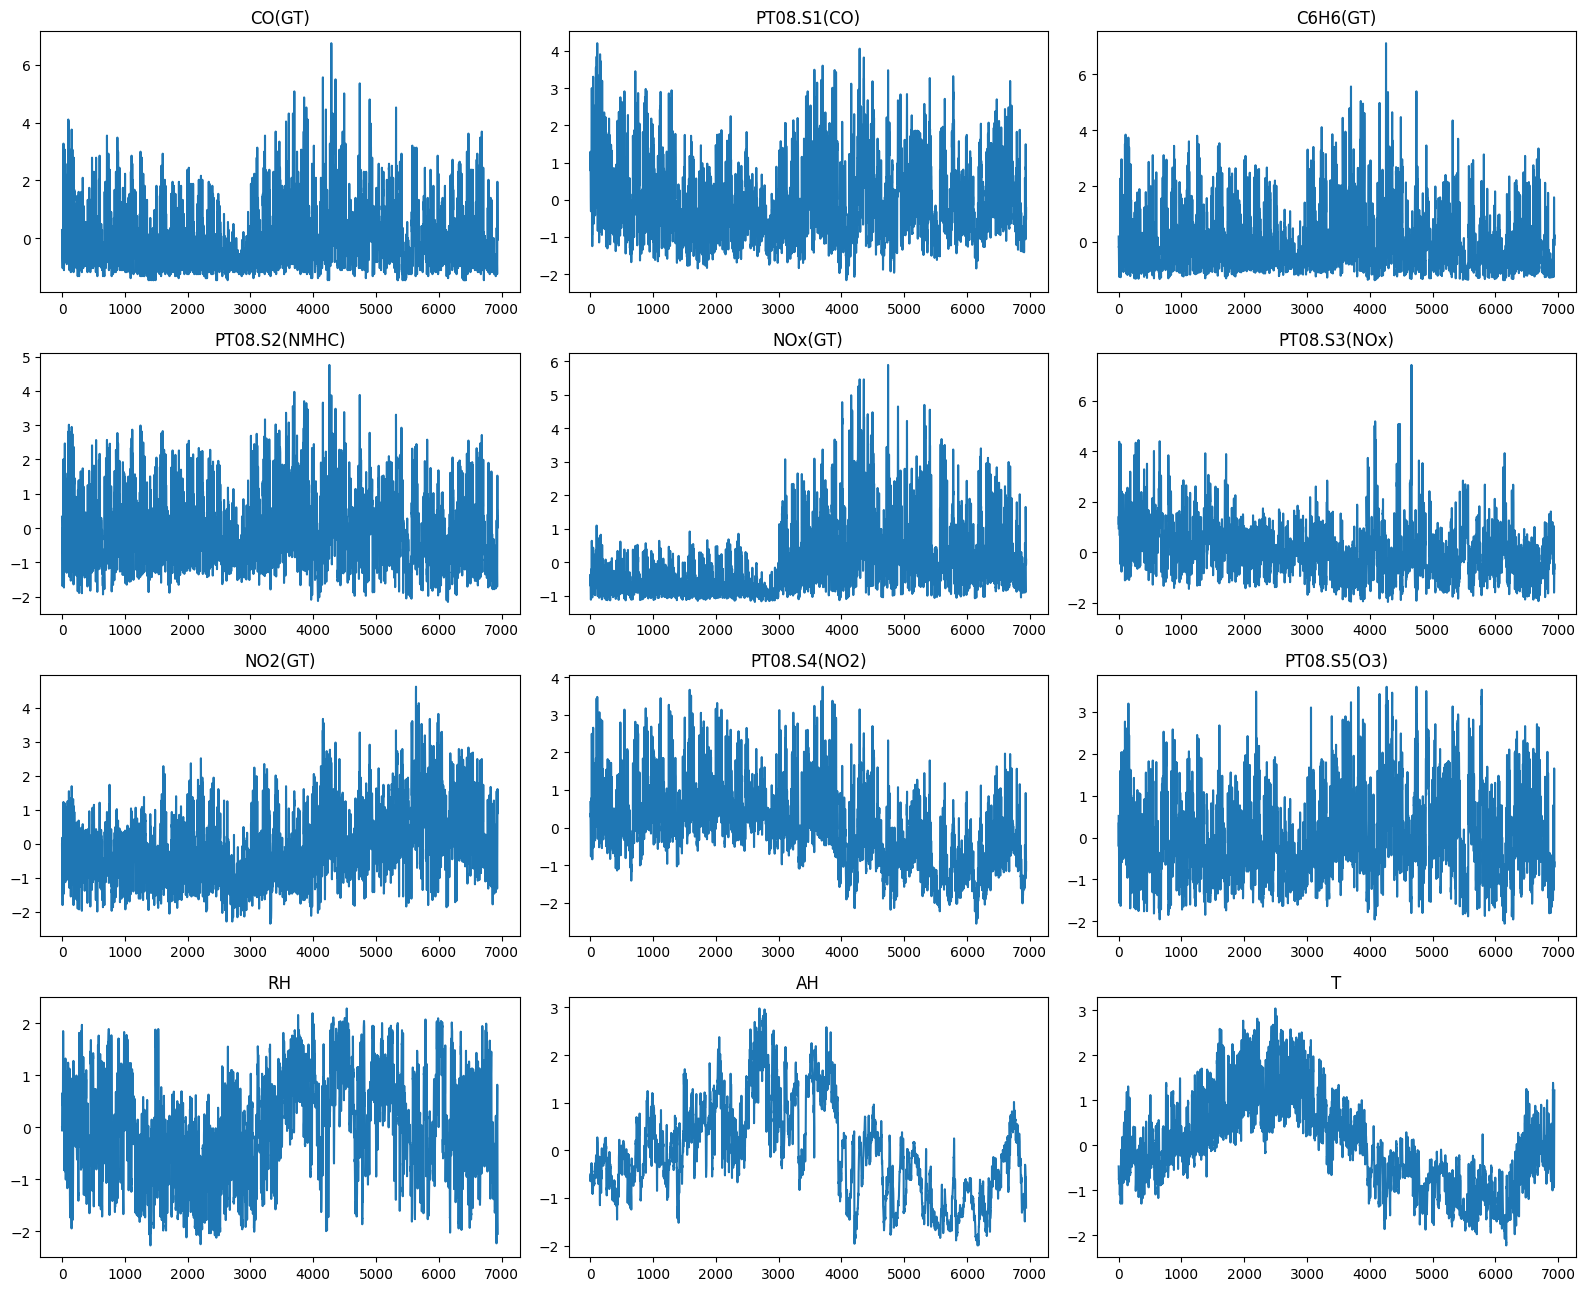

In [ ]:
# Plots for each feature
fig, axes = plt.subplots(nrows = 5, ncols = 3, figsize = (16, 16))
axes = axes.flatten()

for i, column in enumerate(df.drop(columns = ['Time']).columns):
    axes[i].plot(df[column])
    axes[i].set_title(column)

if len(df.columns) - 1 < len(axes):
    for j in range(len(df.columns) - 1, len(axes)):
        fig.delaxes(axes[j])

# Adjust subplot spacing
fig.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Sliding Windows for LSTM
def sliding_window(dataframe, n_steps_in, n_steps_out):
    """
    dataframe - Pandas dataframe containing the rows and columns
    n_steps_in - Number of time steps used for prediction
    n_steps_out - Number of time steps to predict
    """

    # Local variables
    X, y = list(), list()

    for i in range(len(dataframe)):
        # Calculate indexes
        end_idx = i + n_steps_in
        out_end_idx = end_idx + n_steps_out - 1

        # Exit condition
        if out_end_idx > len(dataframe): break

        # Slice sequence
        seq_x, seq_y = dataframe.iloc[i:end_idx, :], dataframe.iloc[end_idx - 1:out_end_idx, -1]

        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

In [ ]:
# Step parameters
n_steps_in = 1024
n_steps_out = 24
n_features = len(df.columns)

# Split data into train and test
train_size = int(len(df) * 0.75)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size - n_steps_in:].reset_index(drop = True) # Adjusting test size to account for lost steps.

train_X, train_y = sliding_window(train_df, n_steps_in, n_steps_out)
test_X, test_y = sliding_window(test_df, n_steps_in, n_steps_out)


# Verify Shapes for LSTM model
print("Train X: ",train_X.shape)
print("Train Y: ",train_y.shape)
print("Test X: ",test_X.shape)
print("Test Y: ",test_y.shape)

Train X:  (4159, 1024, 13)
Train Y:  (4159, 24)
Test X:  (1714, 1024, 13)
Test Y:  (1714, 24)


In [ ]:
df.head()

,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),RH,AH,T
0,0.877653,0.289742,1.097700,0.180250,0.331231,-0.405913,0.949291,-0.018413,0.677518,0.517229,0.001038,-0.567916,-0.469832
1,1.024422,-0.126620,0.786797,-0.154660,-0.013419,-0.707932,1.417770,-0.460783,0.301042,-0.210973,-0.067801,-0.648451,-0.503752
2,1.171191,0.012167,1.289728,-0.208246,-0.074016,-0.573701,1.282785,0.002653,0.289720,0.039961,0.293605,-0.586865,-0.662047
3,1.317960,0.012167,1.170853,-0.181453,-0.039930,-0.377149,1.092217,0.171174,0.371809,0.357320,0.637800,-0.495858,-0.763808
4,1.464728,-0.404195,0.695355,-0.543156,-0.464115,-0.573701,1.540845,0.044783,0.105728,0.128526,0.614854,-0.490622,-0.741194


<ipython-input-16-39335c4f6833>:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['Datetime'] = pd.date_range(start=start_time, periods=len(df), freq='H')


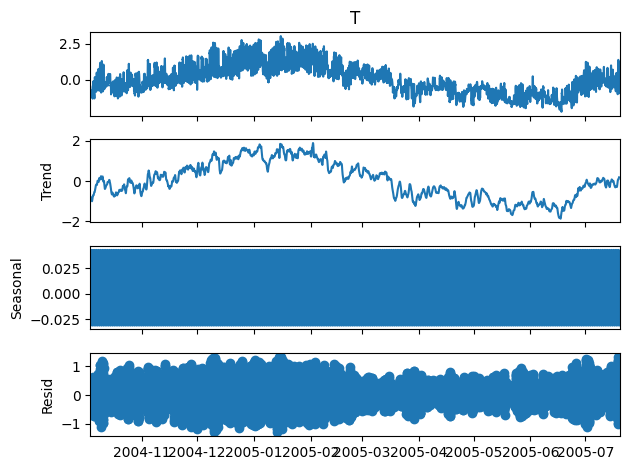

<ipython-input-16-39335c4f6833>:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df.resample('M').mean()


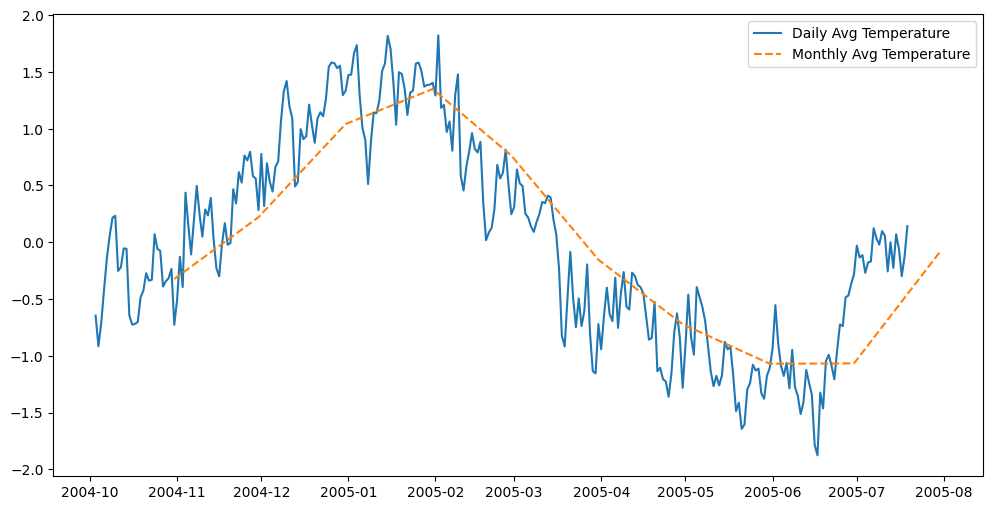

In [ ]:
# Generate a synthetic datetime index
# Assuming the dataset starts at '2004-10-03 18:00:00' and data is hourly
start_time = pd.Timestamp('2004-10-03 18:00:00')
df['Datetime'] = pd.date_range(start=start_time, periods=len(df), freq='H')
df.set_index('Datetime', inplace=True)

# Temporal decomposition for temperature ('T')
decomposed = sm.tsa.seasonal_decompose(df['T'], model='additive', period=24)  # 24-hour period
fig = decomposed.plot()
plt.show()

# Daily and monthly averages
daily_avg = df.resample('D').mean()
monthly_avg = df.resample('M').mean()

plt.figure(figsize=(12, 6))
plt.plot(daily_avg['T'], label='Daily Avg Temperature')
plt.plot(monthly_avg['T'], label='Monthly Avg Temperature', linestyle='--')
plt.legend()
plt.show()


In [ ]:
# Create pollutant ratios and rolling averages
df['CO_NO2_Ratio'] = df['CO(GT)'] / (df['NO2(GT)'] + 1e-5)
df['Rolling_Avg_PM2.5'] = df['PT08.S5(O3)'].rolling(window=24).mean()  # Rolling 24-hour average

# Create lag features for temporal dependencies
for lag in range(1, 25):  # 24-hour lag features
    df[f'T_lag_{lag}'] = df['T'].shift(lag)

# Drop rows with NaN values due to lagging
df.dropna(inplace=True)


### Modeling

#### 1) Vector Output Method - Multivariate Multi Input (No Parallel) Multistep Model

In [ ]:
# Build
model = Sequential()
model.add(LSTM(units = 512, input_shape = (n_steps_in, n_features), dropout = 0.4, return_sequences = True))
model.add(LSTM(units = 256, dropout = 0.4, return_sequences = True))
model.add(LSTM(units = 128, dropout = 0.4))
model.add(Dense(n_steps_out))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1024, 512)           │       1,077,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1024, 256)           │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 24)                  │           3,096 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,064,920 (7.88 MB)

 Trainable params: 2,064,920 (7.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile and Train
def decay_schedule(epoch, lr):
    if (epoch % 22 == 0) and (epoch != 0):
        lr = lr * 0.5
    return lr

model.compile(loss = 'mean_squared_error', optimizer = 'Adam')
# Instead of using tf.keras.backend.set_value, directly assign the learning rate
# after compiling the model:
model.optimizer.lr = 0.005
# Alternatively, you can use:
# model.optimizer.learning_rate = 0.005 # For newer Keras versions
# Or if you have tf.keras
# tf.keras.backend.set_value(model.optimizer.lr, 0.005) # If you have tf.keras

lr_scheduler = LearningRateScheduler(decay_schedule)
model.fit(train_X, train_y, epochs = 70, batch_size = 64, callbacks = [lr_scheduler])

Epoch 1/70
65/65 ━━━━━━━━━━━━━━━━━━━━ 30s 358ms/step - loss: 0.4923 - learning_rate: 0.0010
Epoch 2/70
65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 377ms/step - loss: 0.2523 - learning_rate: 0.0010
Epoch 3/70
65/65 ━━━━━━━━━━━━━━━━━━━━ 25s 389ms/step - loss: 0.2024 - learning_rate: 0.0010
Epoch 4/70
65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 379ms/step - loss: 0.1900 - learning_rate: 0.0010
Epoch 5/70
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 386ms/step - loss: 0.1730 - learning_rate: 0.0010
Epoch 6/70
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 385ms/step - loss: 0.1628 - learning_rate: 0.0010
Epoch 7/70
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 383ms/step - loss: 0.1563 - learning_rate: 0.0010
Epoch 8/70
65/65 ━━━━━━━━━━━━━━━━━━━━ 25s 386ms/step - loss: 0.1575 - learning_rate: 0.0010
Epoch 9/70
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 383ms/step - loss: 0.1429 - learning_rate: 0.0010
Epoch 10/70
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 387ms/step - loss: 0.1389 - learning_rate: 0.0010
Epoch 11/70
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 384ms/step - loss: 0.1327 - learning

In [ ]:
# --- Hybrid Model Design (LSTM + XGBoost) ---
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Train-test split for XGBoost
train_size = int(len(df) * 0.75)
X = df.drop(columns=['T'])
y = df['T']
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Train XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)

# Evaluate XGBoost model
xgb_preds = xgb_model.predict(X_test)
# Calculate RMSE without 'squared' argument if your sklearn version is older than 0.22
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_preds)) # Remove squared=False or calculate sqrt manually
mae_xgb = mean_absolute_error(y_test, xgb_preds)
r2_xgb = r2_score(y_test, xgb_preds)
print(f"XGBoost RMSE: {rmse_xgb:.2f}, MAE: {mae_xgb:.2f}, R²: {r2_xgb:.2f}")

XGBoost RMSE: 0.11, MAE: 0.08, R²: 0.97


In [ ]:
### Without data leakage, multi step prediction

y_preds_wodl = []
test_X_flat = np.reshape(test_X, (test_X.shape[0] * test_X.shape[1], test_X.shape[2]))
curr_idx = 0

for i in range(test_X_flat.shape[0]):
    # Exit Condition
    if curr_idx >= (test_X_flat.shape[0] // n_steps_in):
      break

    input = test_X_flat[curr_idx:curr_idx + n_steps_in]
    pred = model.predict(np.reshape(input, (-1, input.shape[0], input.shape[1])))
    test_X_flat[curr_idx + n_steps_in - 1:curr_idx + n_steps_in + n_steps_out - 1, -1] = pred
    curr_idx += n_steps_out

    y_preds_wodl.extend(pred[0])

y_preds_wodl = np.array(y_preds_wodl)
y_preds_wodl = y_preds_wodl.reshape(y_preds_wodl.shape[0], -1)
tdf_wodl = pd.DataFrame(y_preds_wodl, np.arange(len(y_preds_wodl)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

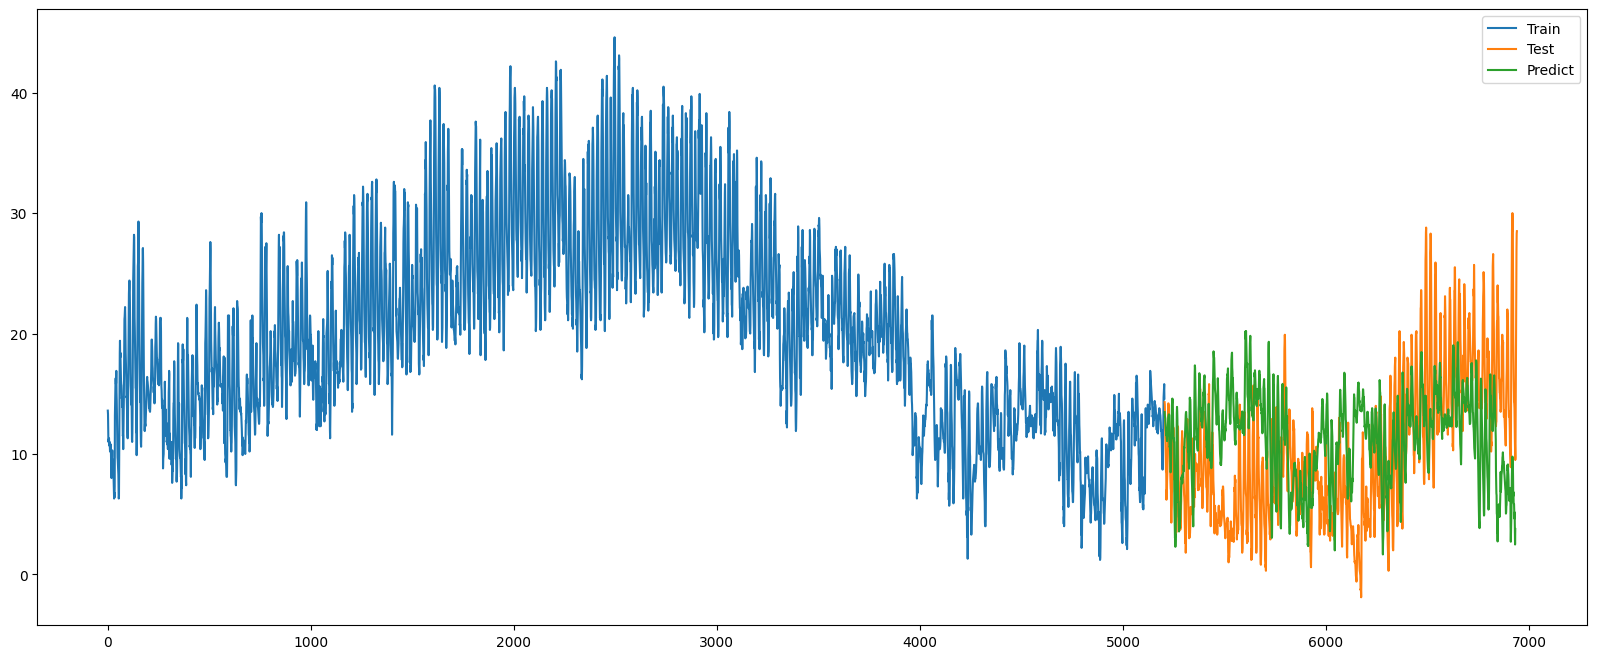

In [ ]:
### Final plot with actual values and predictions
fig, ax = plt.subplots(figsize = (20, 8))

# Scale back the data
col_idx = df.columns.get_loc('T')
t_mean = scaler.mean_[col_idx]
t_scale = scaler.scale_[col_idx]

rescaled_t = (df['T'] * t_scale) + t_mean
rescaled_t_train = (train_df['T'] * t_scale) + t_mean
rescaled_t_test = (test_df['T'] * t_scale) + t_mean
rescaled_t_pred = (tdf_wodl[0] * t_scale) + t_mean

# Training Data
ax.plot(np.arange(rescaled_t_train.shape[0]), rescaled_t_train, label = 'Train')
ax.plot(np.arange(rescaled_t_train.shape[0] + rescaled_t_test.shape[0] - n_steps_in)[rescaled_t_train.shape[0]:], rescaled_t_test[n_steps_in:], label = 'Test')
ax.plot(np.arange(rescaled_t_train.shape[0] + rescaled_t_pred.shape[0])[rescaled_t_train.shape[0]:], rescaled_t_pred, label = 'Predict')

plt.legend(loc = 'upper right')
plt.show()

In [ ]:
print(type(shap_values), len(shap_values) if isinstance(shap_values, list) else shap_values.shape)


<class 'numpy.ndarray'> (100, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

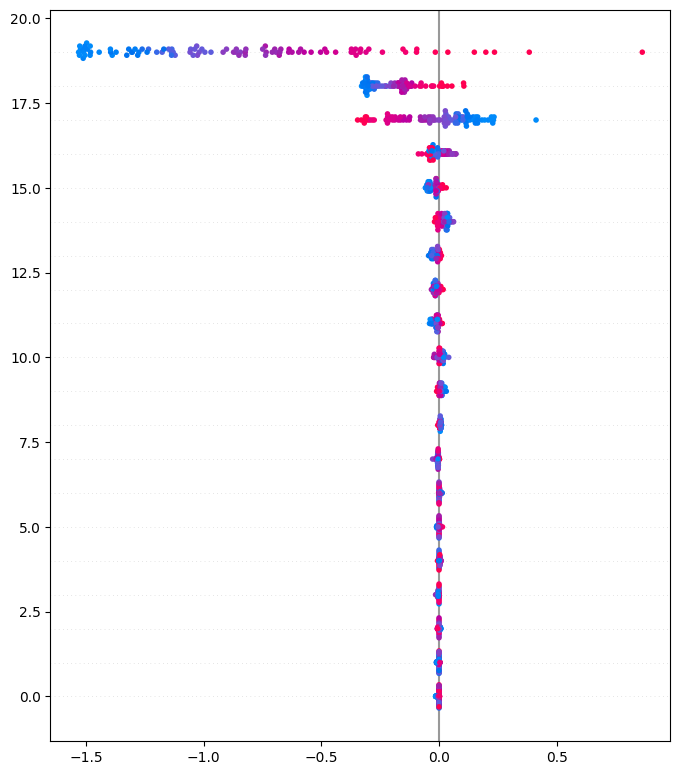

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Fix deprecated np.int usage
shap.explainers._kernel.np.int = int

from shap import KernelExplainer, summary_plot

# Define KernelExplainer
explainer = KernelExplainer(xgb_model.predict, X_train.sample(100, random_state=42))
shap_values = explainer.shap_values(X_test.sample(100, random_state=42))

# Use summary_plot without ax
summary_plot(shap_values, X_test.sample(100, random_state=42), show=False)

# Customize and display the plot
plt.gcf().set_size_inches(12, 6)  # Adjust figure size as needed
plt.show()


#### 2) Encoder-Decoder Method - Multivariate Multi Input (Parallel) Multistep Model

In [ ]:
# Sliding Windows for LSTM - Parallel Inputs
def sliding_window_parallel(dataframe, n_steps_in, n_steps_out):
    """
    dataframe - Pandas dataframe containing the rows and columns
    n_steps_in - Number of time steps used for prediction
    n_steps_out - Number of time steps to predict
    """

    # Local variables
    X, y = list(), list()

    for i in range(len(dataframe)):
        # Calculate indexes
        end_idx = i + n_steps_in
        out_end_idx = end_idx + n_steps_out

        # Exit condition
        if out_end_idx > len(dataframe): break

        # Slice sequence
        seq_x, seq_y = dataframe.iloc[i:end_idx, :], dataframe.iloc[end_idx:out_end_idx, 1:] # Ignoring the time column

        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

In [ ]:
# Step parameters
n_steps_in = 512
n_steps_out = 24
n_features = len(df.columns)

# Split data into train and test
train_size = int(len(df) * 0.75)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size - n_steps_in:].reset_index(drop = True) # Adjusting test size to account for lost steps.

train_X, train_y = sliding_window_parallel(train_df, n_steps_in, n_steps_out)
test_X, test_y = sliding_window_parallel(test_df, n_steps_in, n_steps_out)


# Verify Shapes for LSTM model
print("Train X: ",train_X.shape)
print("Train Y: ",train_y.shape)
print("Test X: ",test_X.shape)
print("Test Y: ",test_y.shape)

Train X:  (4652, 512, 39)
Train Y:  (4652, 24, 38)
Test X:  (1707, 512, 39)
Test Y:  (1707, 24, 38)


In [ ]:
# Build
model = Sequential()
model.add(LSTM(units = 256, input_shape = (n_steps_in, n_features), dropout = 0.4)) # Encoder
model.add(RepeatVector(n_steps_out))
model.add(LSTM(units = 256, dropout = 0.4, return_sequences = True)) # Decoder
model.add(TimeDistributed(Dense(n_features - 1))) # -1 for Time Column
model.summary()

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 256)                 │         303,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 24, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 24, 256)             │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 24, 38)              │           9,766 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 838,182 (3.20 MB)

 Trainable params: 838,182 (3.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile and Train
def decay_schedule(epoch, lr):
    if (epoch % 50 == 0) and (epoch != 0):
        lr = lr * 0.5
    return lr

model.compile(loss = 'mean_squared_error', optimizer = 'Adam')
# Instead of using tf.keras.backend.set_value, directly assign the learning rate
# after compiling the model:
model.optimizer.lr = 0.005
# Alternatively, you can use:
# model.optimizer.learning_rate = 0.005 # For newer Keras versions
# Or if you have tf.keras
# tf.keras.backend.set_value(model.optimizer.lr, 0.005) # If you have tf.keras

lr_scheduler = LearningRateScheduler(decay_schedule)
model.fit(train_X, train_y, epochs = 200, batch_size = 128, callbacks = [lr_scheduler])

Epoch 1/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 15.0389 - learning_rate: 0.0010
Epoch 2/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 13.6284 - learning_rate: 0.0010
Epoch 3/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 13.5227 - learning_rate: 0.0010
Epoch 4/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 13.2849 - learning_rate: 0.0010
Epoch 5/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 12.3974 - learning_rate: 0.0010
Epoch 6/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 13.2112 - learning_rate: 0.0010
Epoch 7/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 14.4301 - learning_rate: 0.0010
Epoch 8/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 13.1728 - learning_rate: 0.0010
Epoch 9/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 12.4548 - learning_rate: 0.0010
Epoch 10/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 12.8598 - learning_rate: 0.0010
Epoch 11/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 13.4451 - learning

In [ ]:
### Without data leakage, multi step prediction

y_preds_wodl = []
test_X_flat = np.reshape(test_X, (test_X.shape[0] * test_X.shape[1], test_X.shape[2]))
curr_idx = 0

for i in range(test_X_flat.shape[0]):
    # Exit Condition
    if curr_idx >= (test_X_flat.shape[0] // n_steps_in):
      break

    input = test_X_flat[curr_idx:curr_idx + n_steps_in]
    pred = model.predict(np.reshape(input, (-1, input.shape[0], input.shape[1])))
    test_X_flat[curr_idx + n_steps_in:curr_idx + n_steps_in + n_steps_out, 1:] = pred
    curr_idx += n_steps_out

    y_preds_wodl.extend(pred[0])

y_preds_wodl = np.array(y_preds_wodl)
y_preds_wodl = y_preds_wodl.reshape(y_preds_wodl.shape[0], -1)
tdf_wodl = pd.DataFrame(y_preds_wodl, np.arange(len(y_preds_wodl)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━

In [ ]:
# Select only the columns the scaler was trained on
numerical_columns = scaler.feature_names_in_  # Ensure these are the same as in the scaler
rescaled_df[numerical_columns] = scaler.inverse_transform(df[numerical_columns])


In [ ]:
print(scaler.feature_names_in_)  # List of columns the scaler was trained on

from sklearn.preprocessing import StandardScaler

# Fit scaler on the numerical columns of the current dataframe
scaler = StandardScaler()
scaler.fit(df[numerical_columns])

# Now perform inverse transform
rescaled_df[numerical_columns] = scaler.inverse_transform(df[numerical_columns])


['Time' 'CO(GT)' 'PT08.S1(CO)' 'C6H6(GT)' 'PT08.S2(NMHC)' 'NOx(GT)'
 'PT08.S3(NOx)' 'NO2(GT)' 'PT08.S4(NO2)' 'PT08.S5(O3)' 'RH' 'AH' 'T']


In [ ]:
# Rescale predictions
# Select only the columns used for scaling (excluding 'Time')
scaling_columns = numerical_columns[1:]  # Assuming 'Time' is the first column

# Create a DataFrame for predictions with the correct column names
pred_df = pd.DataFrame(tdf_wodl, columns=scaling_columns)

# Rescale predictions using the selected columns
rescaled_pred = (pred_df * scaler.scale_[1:]) + scaler.mean_[1:]
# or:
# rescaled_pred = scaler.inverse_transform(pred_df) # If scaler was fitted on all features used in pred_df

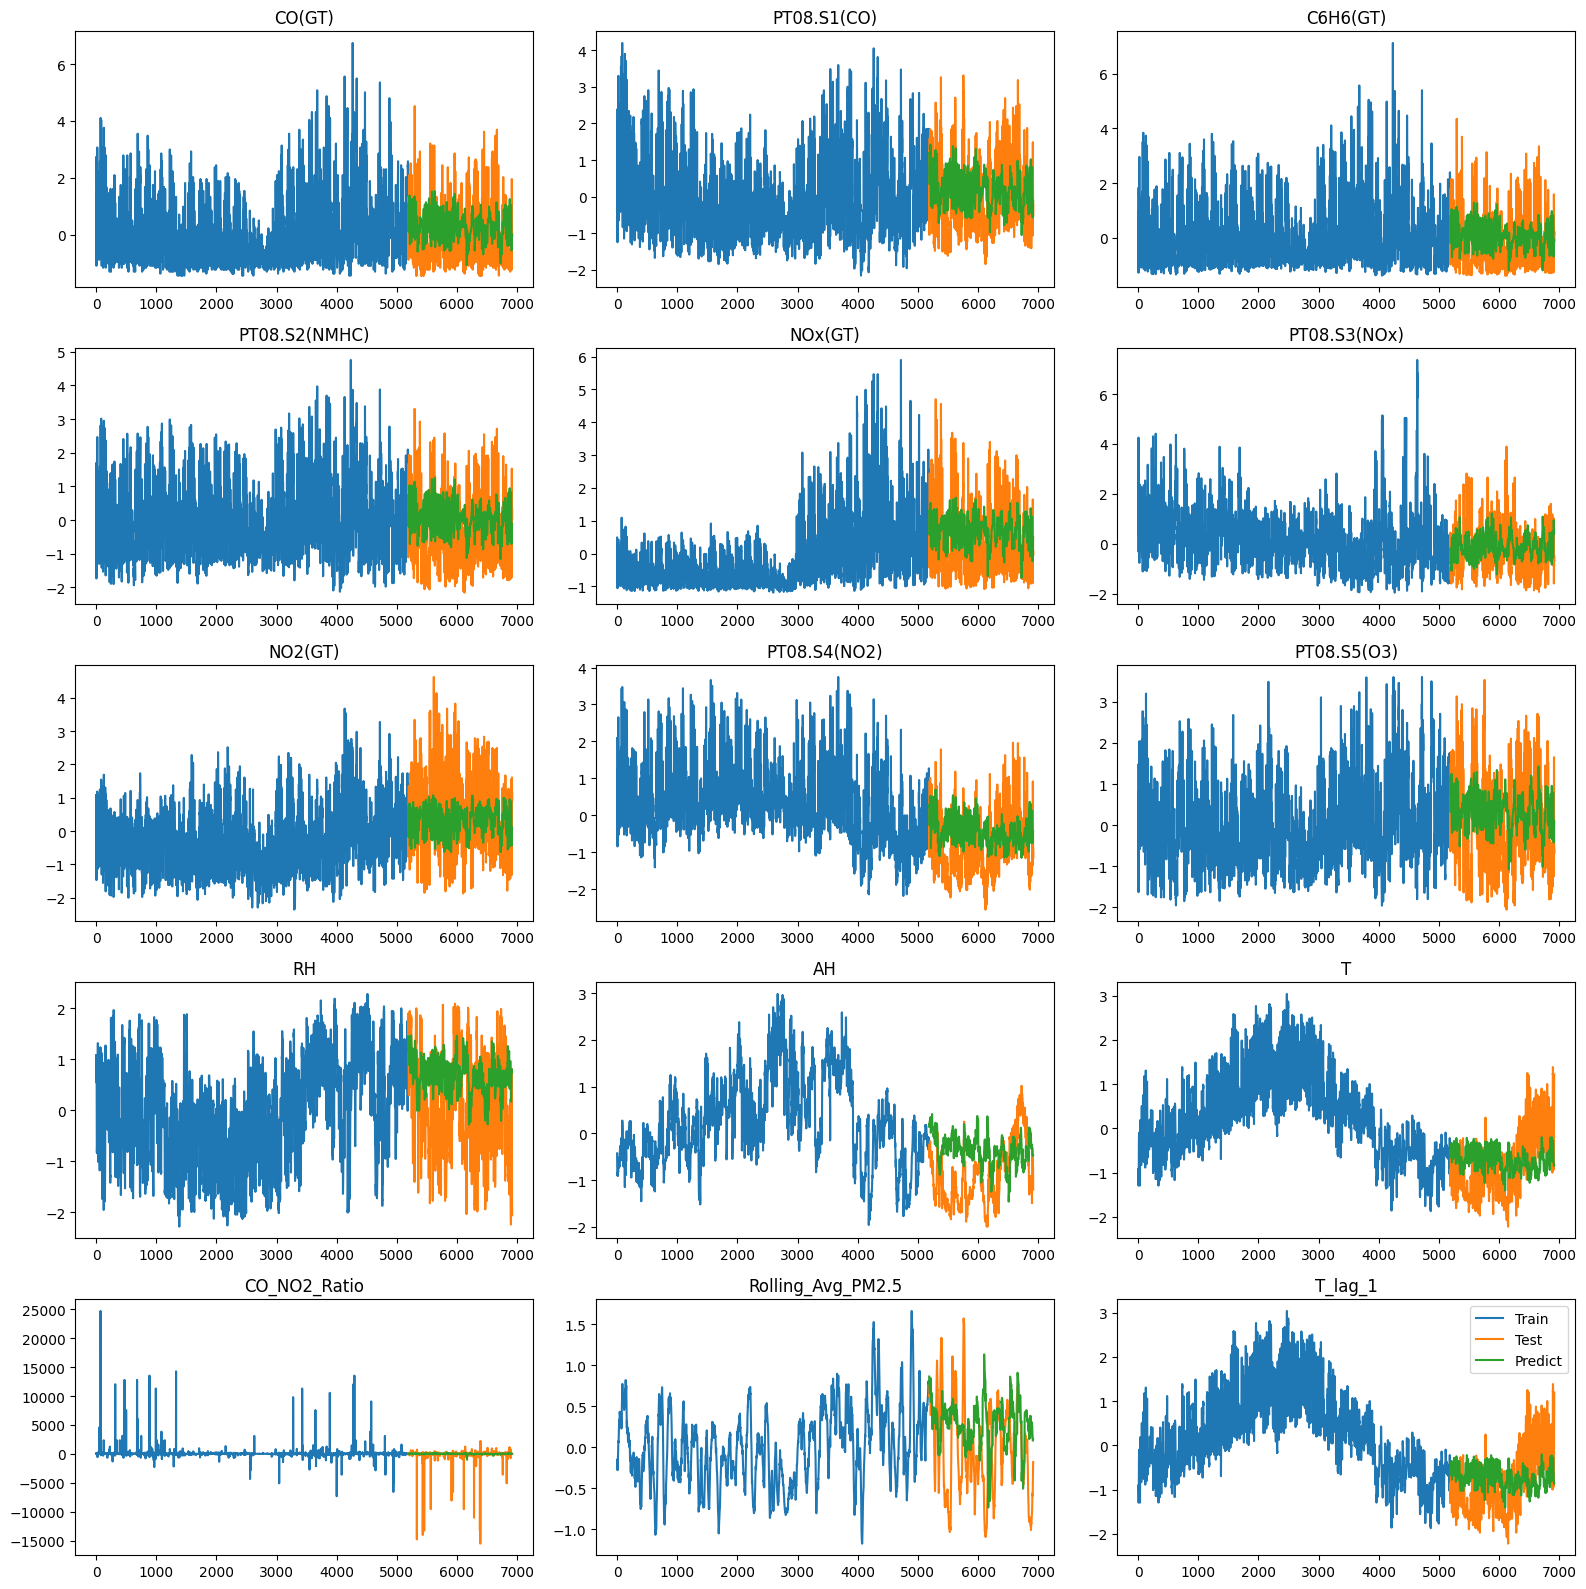

In [ ]:
# Ensure scaler is consistent with the numerical columns
numerical_columns = df.select_dtypes(include=['int', 'float']).columns

# Check if the scaler was previously fitted
# If not, or if the number of features doesn't match, refit the scaler
if not hasattr(scaler, 'n_features_in_') or scaler.n_features_in_ != len(numerical_columns):
    print("Refitting the scaler to match the current data...")  # Optional message
    scaler = StandardScaler()
    scaler.fit(df[numerical_columns])

# Now the assertion should pass
assert len(numerical_columns) == len(scaler.mean_), "Scaler and data mismatch!"


# Inverse transform only on the columns the scaler was fitted on
rescaled_df = df.copy()
rescaled_df[numerical_columns] = scaler.inverse_transform(df[numerical_columns])

rescaled_train = train_df.copy()
# Apply inverse_transform to all numerical columns and select all columns
rescaled_train[numerical_columns] = scaler.inverse_transform(train_df[numerical_columns])

rescaled_test = test_df.copy()
# Apply inverse_transform to all numerical columns and select all columns
rescaled_test[numerical_columns] = scaler.inverse_transform(test_df[numerical_columns])

# Rescale predictions
# Use all columns except 'Time' for rescaling
column_mean = scaler.mean_[1:]  # Exclude the first feature ('Time')
column_scale = scaler.scale_[1:]
# Ensure tdf_wodl has the correct number of columns for rescaling
tdf_wodl_reshaped = tdf_wodl.iloc[:, :len(column_mean)]  # Select only the relevant columns
rescaled_pred = np.array((tdf_wodl_reshaped * column_scale) + column_mean)


# Plotting
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(16, 16))
axes = axes.flatten()

# Get the columns you want to plot (excluding 'Time')
plot_columns = df.drop(columns=['Time']).columns

# Ensure the number of plots and columns match
num_plots = min(len(plot_columns), len(axes))  # Limit to the smaller number

for i, column in enumerate(plot_columns[:num_plots]):  # Iterate up to num_plots
    # Use .loc to select the column by name, avoiding index issues
    axes[i].plot(np.arange(rescaled_train.shape[0]), rescaled_train.loc[:, column], label='Train')
    axes[i].plot(
        np.arange(rescaled_train.shape[0] + rescaled_test.shape[0] - n_steps_in)[rescaled_train.shape[0]:],
        rescaled_test.loc[n_steps_in:, column],  # Use .loc here as well
        label='Test'
    )
    axes[i].plot(
        np.arange(rescaled_train.shape[0] + rescaled_pred.shape[0])[rescaled_train.shape[0]:],
        rescaled_pred[:, i],
        label='Predict'
    )
    axes[i].set_title(column)

# Remove any extra subplots that are not used
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.legend(loc='upper right')
plt.show()

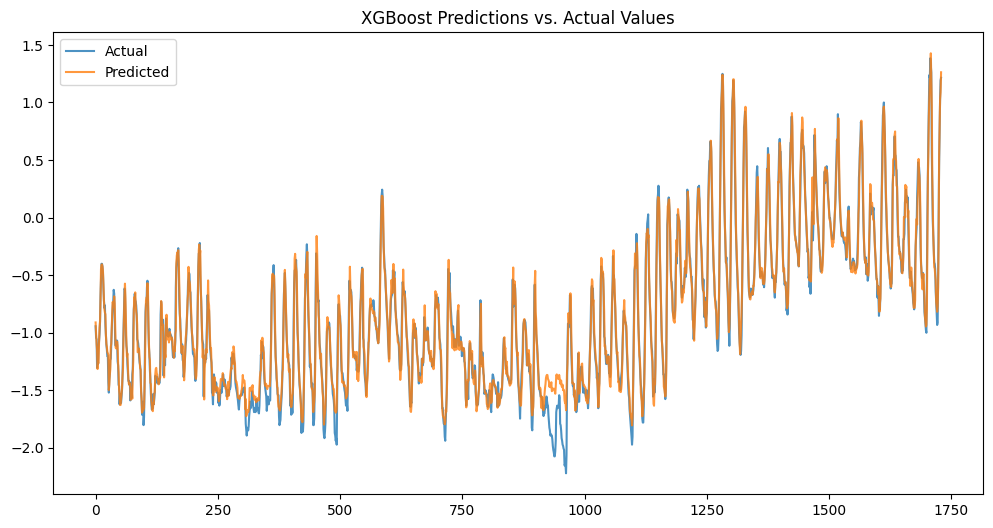

In [ ]:
# --- Outcome Visualization ---
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', alpha=0.8)
plt.plot(xgb_preds, label='Predicted', alpha=0.8)
plt.title('XGBoost Predictions vs. Actual Values')
plt.legend()
plt.show()
